Survey Response Analysis
---
Author: Peter Zhang

This notebook performs the core survey analysis for the results in the paper.

In [564]:
from collections import Counter, defaultdict
import datetime as dt
from itertools import product
from os.path import join
import json
import random

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, pearsonr, brunnermunzel
import seaborn as sns
from sklearn.calibration import calibration_curve
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm
from wordcloud import WordCloud

import config

# Preprocess

Loading survey responses and processing them into a dataframe of questions. The survey responses `.csv` is directly exported from the *Data Analysis* tab of Qualtrics.

In [565]:
responses_folder = "../data/survey_responses"
responses_file = "hmc-v1_April 25, 2023_12.27.csv" 
survey_df = pd.read_csv(join(responses_folder, responses_file)).iloc[2:]
MIN_TIME = 1000 # minimum seconds to consider a survey response
survey_df = survey_df[(survey_df['Status'] == 'IP Address') & (survey_df['Duration (in seconds)'].astype(int) > MIN_TIME)]
print(f"Number of survey responses: {len(survey_df)}")

Number of survey responses: 152


/var/folders/xd/l62jq5mx63qdtc0pktr47qrh0000gn/T/ipykernel_35837/1485539477.py:3: DtypeWarning: Columns (4,5,6,9,10,11,12,13,14,29,30,31,32,33,34,35,36,37,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,2

In [566]:
survey_df['score'] = survey_df['score'].astype(float) # turn score to float
usage_cols = ['heard_of', 'used', 'used_in_class', 'answered_mc'] # each level of usage
for col in usage_cols:
    survey_df[col] = survey_df[col] == 'Yes' # encode as boolean

Create mappings for each familiarity topic area index to the name of the topic.

In [567]:
familiarity_cols = [f"familiarity_{i}" for i in range(1, 9)]
familiarity_topics = [
    'Mathematics',
    'Literature',
    'History',
    'Economics',
    'Biological Sciences',
    'Physics',
    'Computer Science',
    'Trivia',
]
topic2col = dict(zip(familiarity_topics, familiarity_cols))

Map each response to the majors question to a manually encoded list of majors in the `majors_rename.json` file.

In [568]:
majors_file = "majors_rename.json"
majors_dict = defaultdict(lambda: "Other")
majors_dict.update(json.load(open(join(responses_folder, majors_file), 'r')))
rename_majors = lambda orig_major: majors_dict[orig_major].split(',')
survey_df['major'] = survey_df['major'].apply(rename_majors)

In [569]:
PARTICIPANT_COLS = ['score', 'major'] + usage_cols + familiarity_cols # list of all participant-level features

## Link to Questions

We connect survey responses to the list of questions from each question phase.

In [570]:
def date2phase(date: dt.date) -> str:
    """Classify survey phase."""
    if date < dt.date(2023, 4, 4):
        return 'tests'
    if date <  dt.date(2023, 4, 13):
        return 'pilots'
    elif date == dt.date(2023, 4, 13):
        return 'phase 1'
    elif (date >= dt.date(2023, 4, 17)) and (date < dt.date(2023, 4, 21)):
        return 'phase 2'
    elif date >= dt.date(2023, 4, 21):
        return 'phase 3'
    return 'drop'
survey_df['date'] = pd.to_datetime(survey_df['RecordedDate']).dt.date
survey_df['phase'] = survey_df['date'].apply(date2phase)
survey_df = survey_df[survey_df['phase'].isin(['phase 1', 'phase 2', 'phase 3'])] # only consider responses from the 3 phases
survey_df = survey_df[survey_df['source'] == 'rpp'] # restrict to rpp survey respondents

In [571]:
phase2fp = {
    'phase 1':'../data/survey_questions/qualtrics_0413.json',
    'phase 2':'../data/survey_questions/qualtrics_0417.json',
    'phase 3':'../data/survey_questions/qualtrics_0421.json',
}
def clean_qualtrics(qualtrics):
    """Extract answers from qualtrics json file."""
    qualtrics = {int(q): qualtrics[q] for q in qualtrics}
    for k, v in qualtrics.items():
        question, optionA, optionB, optionC, optionD, advice_answer, justification, correct_answer, topic = v
        qualtrics[k] = {
            'question': question,
            'optionA': optionA,
            'optionB': optionB,
            'optionC': optionC,
            'optionD': optionD,
            'correct_answer': correct_answer,
            'justification': justification,
            'advice_answer': advice_answer,
            'topic': topic,
        }
    return qualtrics
load_json = lambda fp: json.loads(open(fp, 'r').read().replace('\\\\','\\'))
pipeline = lambda fp: clean_qualtrics(load_json(fp))
phase2qualtrics = {wave:pipeline(fp) for wave, fp in phase2fp.items()}

In [572]:
row2columns = {}
columns = survey_df.columns
column_numbers = [int(c.split('_')[0]) for c in columns[columns.str.contains('adjustment_1')]]  # get names of all columns
for i, row in survey_df.iterrows():
    answered = columns[columns.str.contains('adjustment_1') & ~(row[columns].isna())]
    row2columns[i] = set([c.split('_')[0] for c in answered])
col2q = dict(zip(column_numbers, range(1, len(column_numbers)+1)))

This core loop converts each response to a set of rows with each row representing a question.

In [573]:
question_dataset = []
for idx, row in survey_df.iterrows():

    # get the questions list
    questions_list = row2columns[idx]

    participant_data = {
        'participant_id':row['ResponseId'],
        'advisor': row['advisor'],
        'source': row['source'],
        'give_justification': row['justification'],
    }

    for col in PARTICIPANT_COLS:
        participant_data[col] = row[col]

    for i, columnnum in enumerate(questions_list):
        columnnum = int(columnnum)
        question_data = {}
        init_total = sum([float(row[f'{columnnum}_question_{choice_num}']) for choice_num in [1, 2, 3, 4]])
        adjusted_total = sum([float(row[f'{columnnum}_adjustment_{choice_num}']) for choice_num in [1, 2, 3, 4]])
        for choice_num, letter in zip([1, 2, 3, 4], ['A', 'B', 'C', 'D']):
            question_data[f'init_choice{letter}'] = float(row[f'{columnnum}_question_{choice_num}']) / init_total
            question_data[f'adjusted_choice{letter}'] = float(row[f'{columnnum}_adjustment_{choice_num}']) / adjusted_total

        question_num = col2q[columnnum]
        question_data['question_num'] = i+1
        qualtrics = phase2qualtrics[row['phase']]
        question_meta = qualtrics[question_num]
        question_data.update(question_meta)
        question_data.update(participant_data)
        question_dataset.append(question_data)

Link to comfort in topic.

In [574]:
question_df = pd.DataFrame(question_dataset)
output_file = "../data/cleaned_responses/" + responses_file.replace('.csv', '_cleaned.csv')
question_df.to_csv(output_file, index=False)
question_n = len(question_df)
participant_n = len(question_df['participant_id'].unique())
print(f"Cleaned {question_n} questions from {responses_file} with {participant_n} participants.")

Cleaned 2828 questions from hmc-v1_April 25, 2023_12.27.csv with 118 participants.


## Calculate Weight on Advice

Calculate weight on advice.

In [575]:
question_df = question_df[~question_df['correct_answer'].isna()]
def calc_woa_logg(row):
    """Calculate weight on advice following Logg et al. (2019)."""
    if row['advice_answer'] not in 'ABCD':
        return 0
    elif 1-row[f'init_choice{row["advice_answer"]}'] == 0:
        return 0
    else:
        return (row[f'adjusted_choice{row["advice_answer"]}'] - \
            row[f'init_choice{row["advice_answer"]}'])/(1-row[f'init_choice{row["advice_answer"]}'])
    
def calc_woa(row: pd.Series, adjusted_col: str='adjusted'):
    """Calculate our measure of weight on advice."""
    if row['advice_answer'] not in 'ABCD':
        return 0
    return row[f'{adjusted_col}_choice{row["advice_answer"]}'] - \
            row[f'init_choice{row["advice_answer"]}']

question_df['weight_on_advice'] = question_df.apply(calc_woa_logg, axis=1)

Windsorize negative weight of advice, a standard practice since negative WOA can't be rationalized.

In [576]:
neg_woa_count = sum(question_df['weight_on_advice'] < 0)
print(f"winsorizing {neg_woa_count} questions with negative weight on advice which is {neg_woa_count/len(question_df):.2%}% of the dataset")
question_df['weight_on_advice'] = question_df['weight_on_advice'].clip(lower=0)

winsorizing 166 questions with negative weight on advice which is 5.87%% of the dataset


### Familarity

In [577]:
question_df['fam_topic'] = question_df['topic'].apply(config.topic2fam_topic.get)
def get_topic_familiarity(row):
    """Gets the familiarity level of the participant for the familiarity topic category."""
    col = topic2col[row["fam_topic"]]
    return row[col]
question_df['topic_familiarity'] = question_df.apply(get_topic_familiarity, axis=1)

# Analysis

This section analyzes the `question_df` generated before.

In [578]:
num_unique_questions = len(question_df['question'].unique())
print(f"Participants were shown {num_unique_questions} unique questions.")

Participants were shown 684 unique questions.


## Summary Statistics

From the section `Appendix B.1`.

Counts of participants in each condition.

In [579]:
print(question_df.groupby(['advisor', 'give_justification']).agg({'participant_id':'nunique'}))
print(f"Participants answered an average of {question_n/participant_n:.2f} questions.")
print(f"{sum(question_df.groupby('participant_id').agg({'question_num':'nunique'})['question_num'] == 40)} participants answered all 40 questions.")

                               participant_id
advisor    give_justification                
AI chatbot no                              24
           yes                             32
expert     no                              28
           yes                             34
Participants answered an average of 23.97 questions.
8 participants answered all 40 questions.


Average WoA was 0.337 with a standard deviation of 0.395
Proportion of WoA set to 0: 40.45%


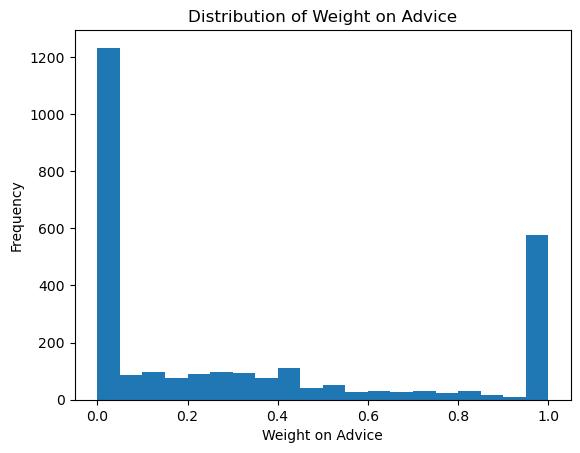

In [580]:
print(f"Average WoA was {question_df['weight_on_advice'].mean():.3f} with a standard deviation of {question_df['weight_on_advice'].std():.3f}")
print(f"Proportion of WoA set to 0: {(question_df['weight_on_advice'] == 0).mean():.2%}")
question_df['weight_on_advice'].plot.hist(bins=20)
plt.title("Distribution of Weight on Advice")
plt.xlabel("Weight on Advice")
plt.ylabel("Frequency")
plt.savefig("../figures/weight_on_advice_dist.png")
plt.show()

Generates table of summary statistics.

In [581]:
# summary stat columns
cols = ['weight_on_advice', 'topic_familiarity', 'question_num', 'give_justification', 'advisor', 'source', 'question', 'correct_answer', 'advice_answer']
summary_df = question_df[cols].copy()
summary_df['correct'] = (summary_df['correct_answer'] == summary_df['advice_answer']).astype(int)
summary_df["advisor:AI chatbot"] = (summary_df['advisor'] == 'AI chatbot').astype(int)
summary_df["give_justification:yes"] = (summary_df['give_justification'] == 'yes').astype(int)
summary_df["advice_is_correct"] = (summary_df['correct_answer'] == summary_df['advice_answer']).astype(int)
# round to 2 decimals
summary_df.describe().round(3).to_latex("../tables/summary_stats.tex")
print(summary_df.describe().round(2).to_string())

       weight_on_advice  question_num  correct  advisor:AI chatbot  give_justification:yes  advice_is_correct
count           2828.00       2828.00  2828.00             2828.00                 2828.00            2828.00
mean               0.34         13.10     0.64                0.46                    0.57               0.64
std                0.40          8.15     0.48                0.50                    0.50               0.48
min                0.00          1.00     0.00                0.00                    0.00               0.00
25%                0.00          6.00     0.00                0.00                    0.00               0.00
50%                0.15         12.00     1.00                0.00                    1.00               1.00
75%                0.67         18.00     1.00                1.00                    1.00               1.00
max                1.00         40.00     1.00                1.00                    1.00               1.00


/var/folders/xd/l62jq5mx63qdtc0pktr47qrh0000gn/T/ipykernel_35837/1582285097.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  summary_df.describe().round(3).to_latex("../tables/summary_stats.tex")


Participants answered an average of 24.0 questions.
Number of participant who answered 25 questions or less: 92
Number of participant who answered more than 25 questions: 26


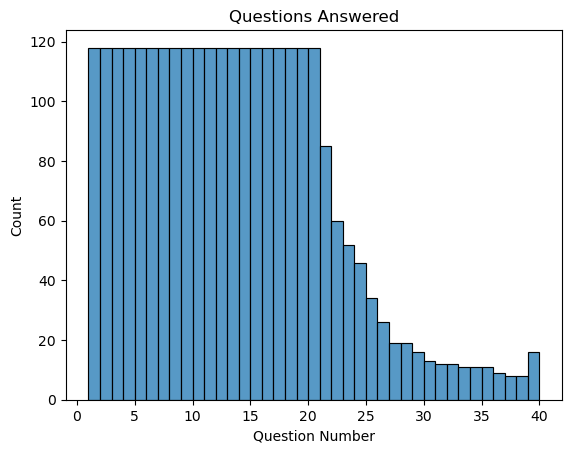

In [582]:
question_df['question_group'] = pd.cut(question_df['question_num'], bins=range(0, 41, 5))
print(f"Participants answered an average of {question_df.groupby('participant_id')['question_num'].count().mean():.1f} questions.")
print(f"Number of participant who answered 25 questions or less: {len(question_df.groupby('participant_id').filter(lambda x: len(x) <= 25)['participant_id'].unique())}")
print(f"Number of participant who answered more than 25 questions: {len(question_df.groupby('participant_id').filter(lambda x: len(x) > 25)['participant_id'].unique())}")
sns.histplot(data=question_df, x="question_num", bins=np.arange(1, 41))
plt.xlabel("Question Number")
plt.title("Questions Answered")
plt.savefig('../figures/questions_answered.png')
plt.show()

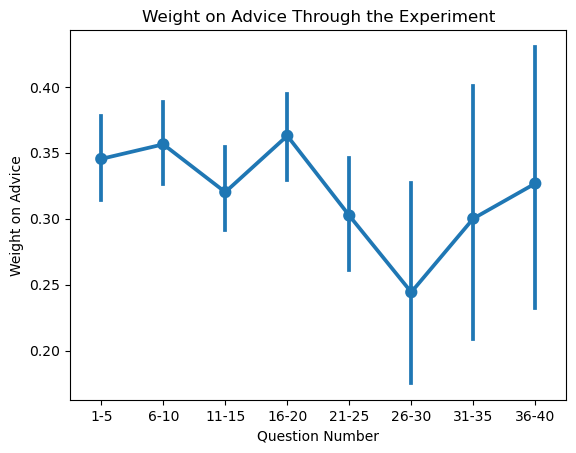

In [583]:
g = sns.pointplot(data=question_df, x="question_group", y="weight_on_advice", errorbar=('ci',95))
plt.title('Weight on Advice Through the Experiment')
plt.xlabel('Question Number')
g.set_xticklabels(labels=[f'{i}-{i+4}' for i in range(1, 41, 5)])
plt.ylabel('Weight on Advice')
plt.savefig('../figures/over_questions.png')
plt.show()

Analysis of variance for question group.

In [584]:
model = smf.ols('weight_on_advice ~ C(question_group)', data=question_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(question_group),2.039624,7.0,1.86922,0.07052
Residual,439.582856,2820.0,NaN,NaN


Participant majors.

In [585]:
participant_df = question_df.groupby('participant_id')[PARTICIPANT_COLS].first()
for fam_col in familiarity_cols:
    participant_df[fam_col] = participant_df[fam_col].apply(comfort_map.get)
major_counts = Counter()
participant_df['major'].apply(lambda x: major_counts.update([s.strip() for s in x]))
major_counts

Counter({'Business Administration': 93,
         'Political Economy': 3,
         'EECS': 9,
         'Economics': 6,
         'Psychology': 10,
         'Cognitive Science': 2,
         'Data Science': 19,
         'Materials Science Engineering': 1,
         'Computer Science': 10,
         'Molecular and Cell Biology': 5,
         'Mechanical Engineering': 1,
         'Media Studies': 2,
         'Neurobiology': 1,
         'Science and Technology Studies': 1,
         'Environmental Economics and Policy': 1,
         'City and Regional Planning': 1,
         'Mathematics': 1,
         'Demography': 1,
         'Chemical Engineering': 2,
         'Ancient Greek and Roman Studies': 1,
         'Public Health': 1,
         'Bioengineering': 3,
         'Political Science': 1,
         'Chinese': 1,
         'Interdisciplinary Studies Field': 1})

## Topic Familiarity

From the section `Appendix B.2`. First calculate overall accuracy.

In [586]:
def pick_answer(row: pd.Series, type=str) -> str:
    """Pick answer based on confidence and randomly tiebreak."""
    assert type in ('init', 'adjusted', 'simulated'), 'type must be init or adjusted'

    random.seed(0)
    choices = [row[f'{type}_choice{letter}'] for letter in ['A', 'B', 'C', 'D']]
    max_conf = max(choices)
    choices = [letter for letter, conf in zip(['A', 'B', 'C', 'D'], choices) if conf == max_conf]
    return random.choice(choices)

question_df['init_answer'] = question_df.apply(pick_answer, axis=1, type='init')
question_df['init_answer_correct'] = question_df['init_answer'] == question_df['correct_answer']
question_df['adjusted_answer'] = question_df.apply(pick_answer, axis=1, type='adjusted')
question_df['adjusted_answer_correct'] = question_df['adjusted_answer'] == question_df['correct_answer']

In [587]:
question_df['advice_is_correct'] = (question_df['advice_answer'] == question_df['correct_answer'])
ANSWER_COLS = ['init_answer_correct', 'adjusted_answer_correct', 'advice_is_correct']
COMFORT_LEVELS = ["Combined", 'Uncomfortable', 'Neutral', 'Comfortable']
def eval_accuracy(df, comfort_level, answer_col):
    """Evaluates the mean and standard error of accuracy for a given comfort level."""
    assert answer_col in ANSWER_COLS
    assert comfort_level in COMFORT_LEVELS

    if comfort_level != "Combined":
        df = df[df['topic_familiarity'] == comfort_level]
    
    accuracy = df[answer_col].mean()
    se = df[answer_col].sem()

    return accuracy, se

In [588]:
# evaluate and plot
accuracy_data = []
for answer_col, comfort_level in product(ANSWER_COLS, COMFORT_LEVELS):
    accuracy, se = eval_accuracy(question_df, comfort_level, answer_col)
    accuracy_data.append({'answer_col': answer_col, 'comfort_level': comfort_level, 'accuracy': accuracy, 'se': se})
accuracy_df = pd.DataFrame(accuracy_data, columns=['answer_col', 'comfort_level', 'accuracy', 'se'])

# evaluate which accuracies are significantly different from combined
sig_diff = []
for answer_col in ANSWER_COLS:
    combined_accuracy = accuracy_df[(accuracy_df['answer_col'] == answer_col) & (accuracy_df['comfort_level'] == 'Combined')]['accuracy'].values[0]
    for comfort_level in COMFORT_LEVELS:
        accuracy = accuracy_df[(accuracy_df['answer_col'] == answer_col) & (accuracy_df['comfort_level'] == comfort_level)]['accuracy'].values[0]
        se = accuracy_df[(accuracy_df['answer_col'] == answer_col) & (accuracy_df['comfort_level'] == comfort_level)]['se'].values[0] * 1.96
        if accuracy - se > combined_accuracy or accuracy + se < combined_accuracy:
            sig_diff.append((answer_col, comfort_level))

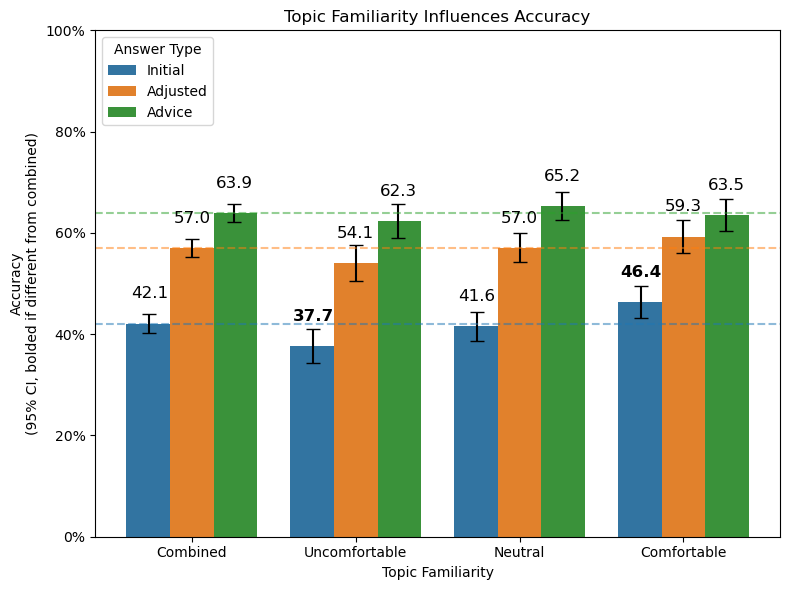

In [589]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=accuracy_df, x='comfort_level', y='accuracy', hue='answer_col', ax=ax)
ax.set_ylim(0, 1)
ax.set_ylabel('Accuracy\n(95% CI, bolded if different from combined)')
ax.set_xlabel('Topic Familiarity')
ax.set_title('Topic Familiarity Influences Accuracy')

# plot error bars
for i, answer_col in enumerate(ANSWER_COLS):
    for j, comfort_level in enumerate(COMFORT_LEVELS):
        accuracy = accuracy_df[(accuracy_df['answer_col'] == answer_col) & (accuracy_df['comfort_level'] == comfort_level)]['accuracy'].values[0]
        se = accuracy_df[(accuracy_df['answer_col'] == answer_col) & (accuracy_df['comfort_level'] == comfort_level)]['se'].values[0] * 1.96
        ax.errorbar(j + i * 0.26 - 0.26, accuracy, yerr=se, fmt='none', color='black', capsize=5)

# draw horizontal lines for combined accuracy
for i, answer_col in enumerate(ANSWER_COLS):
    combined_accuracy = accuracy_df[(accuracy_df['answer_col'] == answer_col) & (accuracy_df['comfort_level'] == 'Combined')]['accuracy'].values[0]
    color = {
        'init_answer_correct': 'tab:blue',
        'adjusted_answer_correct': 'tab:orange',
        'advice_is_correct': 'tab:green'
    }[answer_col]
    ax.axhline(combined_accuracy, color=color, linestyle='--', alpha=0.5)

# annotate accuracy at top of each bar
for i, answer_col in enumerate(ANSWER_COLS):
    for j, comfort_level in enumerate(COMFORT_LEVELS):
        accuracy = accuracy_df[(accuracy_df['answer_col'] == answer_col) & (accuracy_df['comfort_level'] == comfort_level)]['accuracy'].values[0]

        # bold if significantly different from combined
        fontweight = 'bold' if (answer_col, comfort_level) in sig_diff else 'normal'
        ax.annotate(f"{accuracy * 100:.1f}", xy=(j + i * 0.26 - 0.26, accuracy + 0.05), ha='center', fontsize=12, fontweight=fontweight)

# rename legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Initial', 'Adjusted', 'Advice'], title='Answer Type', loc='upper left')

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.savefig('../figures/accuracy_by_answer_type_and_comfort_level.png')
plt.show()

Comfort summary statistics.

In [590]:
comfort_map = { # mapping of comfort level to numerical value
    'Uncomfortable': -1,
    'Neutral': 0,
    'Comfortable': 1,
}
question_df['net_familiarity'] = question_df['topic_familiarity'].apply(comfort_map.get)
sorted_topics = question_df.groupby('fam_topic')['net_familiarity'].mean().sort_values().index

Figure from `Appendix B.1`.

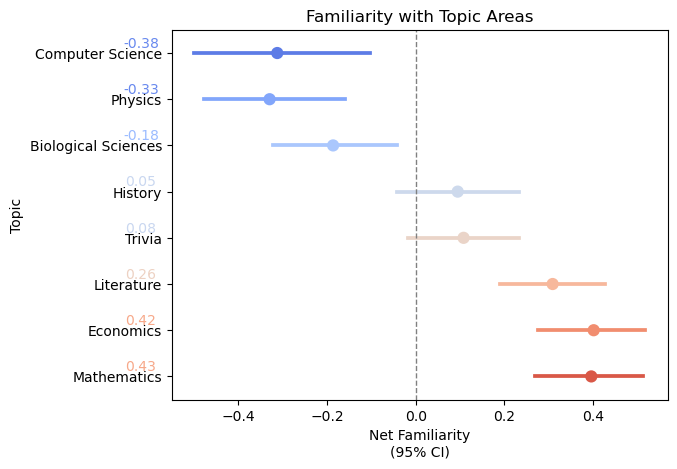

In [591]:
fam_df = question_df.groupby(['participant_id', 'fam_topic', 'net_familiarity']).size().reset_index(name='count')
sns.pointplot(x='net_familiarity', y='fam_topic', data=fam_df, hue_order=COMFORT_LEVELS, palette="coolwarm", order=sorted_topics, orient='h')
# annotate net mean
for i, label in enumerate(plt.gca().get_yticklabels()):
    mean_net_comfort = question_df[question_df['fam_topic'] == label._text]['net_familiarity'].mean()
    color = sns.color_palette("coolwarm")[round(5*mean_net_comfort) + 2]
    plt.gca().text(-.62, i-.12, f"{mean_net_comfort:.2f}", ha='center', color=color)
plt.gca().axvline(0, color='grey', linestyle='--', linewidth=1)  # add thin zero line
# pad top
plt.gca().set_yticklabels(sorted_topics)

plt.ylabel('Topic')
plt.xlabel('Net Familiarity\n(95% CI)')
plt.title('Familiarity with Topic Areas')
plt.savefig('../figures/familiarity.png')
plt.show()

For `Appendix A.1` on question distribution.

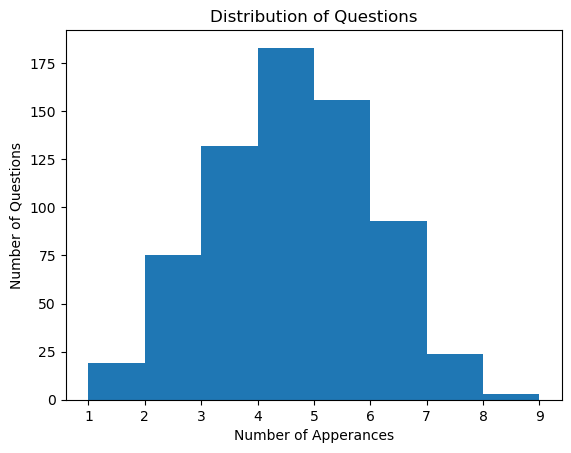

In [592]:
def hash_question(row):
    """Creates a hash from the question text and choice text."""
    text = row["question"]
    for choice in "ABCD":
        text += row[f"option{choice}"]
    return hash(text)
question_df['question_id'] = question_df.apply(hash_question, axis=1)
question_df["participant+question_id"] = question_df["participant_id"].astype(str) + question_df["question_id"].astype(str)
plt.hist(list(question_df['question_id'].value_counts()), bins=max(question_df['question_id'].value_counts() - 1))
plt.xlabel("Number of Apperances")
plt.ylabel("Number of Questions")
plt.title("Distribution of Questions")
plt.savefig('../figures/question_distribution.png')

## Weight on Advice Regression

Regressions from the section `Weight on Advice`.

In [593]:
regression_results = {}
question_df["group"] = 1 # same group for all, necessary for mixed effects

Regression `A`.

In [594]:
formula = "weight_on_advice ~ advisor * give_justification"

vcf = {"question_id": "0 + C(question_id)", "participant_id": "0 + C(participant_id)"}  # formula                                                    
model = sm.MixedLM.from_formula(formula, groups="group",                                                    
                                vc_formula=vcf, data=question_df)                                                   
result = model.fit()  
regression_results['A'] = result
print(result.summary())

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                        Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         weight_on_advice
No. Observations:         2828            Method:                     REML            
No. Groups:               1               Scale:                      0.1116          
Min. group size:          2828            Log-Likelihood:             -1107.5007      
Max. group size:          2828            Converged:                  Yes             
Mean group size:          2828.0                                                      
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                    0.329    0.044  7.507 0.000  0.243  0.415
advisor[T.expert]                           -0.027    0.059 -0.452 0

Regression `B`. Regress on advisor, justification, and comfort level.

In [595]:
formula = "weight_on_advice ~ advisor * give_justification + topic_familiarity"

vcf = {"question_id": "0 + C(question_id)", "participant_id": "0 + C(participant_id)"}  # formula                                                    
model = sm.MixedLM.from_formula(formula, groups="group",                                                    
                                vc_formula=vcf, data=question_df)                                                   
result = model.fit()  
regression_results['B'] = result
print(result.summary())

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                        Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         weight_on_advice
No. Observations:         2828            Method:                     REML            
No. Groups:               1               Scale:                      0.1117          
Min. group size:          2828            Log-Likelihood:             -1109.1272      
Max. group size:          2828            Converged:                  Yes             
Mean group size:          2828.0                                                      
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                    0.302    0.045  6.651 0.000  0.213  0.390
advisor[T.expert]                           -0.028    0.059 -0.468 0

In [596]:
print(result.conf_int().loc['topic_familiarity[T.Uncomfortable]'])

0    0.021874
1    0.100811
Name: topic_familiarity[T.Uncomfortable], dtype: float64


Regression `B2`. Add mixed effects for topic as a robustness check.

In [597]:
formula = "weight_on_advice ~ advisor * give_justification + topic_familiarity"

vcf = {"question_id": "0 + C(question_id)", "participant_id": "0 + C(participant_id)",  "topic": "0 + C(topic)"}  # formula                                                    
model = sm.MixedLM.from_formula(formula, groups="group",                                                    
                                vc_formula=vcf, data=question_df)                                                   
result = model.fit()  
regression_results['B2'] = result
print(result.summary())

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimizatio

                        Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         weight_on_advice
No. Observations:         2828            Method:                     REML            
No. Groups:               1               Scale:                      0.1077          
Min. group size:          2828            Log-Likelihood:             -1109.1759      
Max. group size:          2828            Converged:                  No              
Mean group size:          2828.0                                                      
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                    0.311    0.052  5.929 0.000  0.208  0.414
advisor[T.expert]                           -0.028    0.066 -0.427 0

Regression `B3`. Add interaction term for topic familiarity.

In [598]:
formula = "weight_on_advice ~ advisor * give_justification + topic_familiarity * advisor"

vcf = {"question_id": "0 + C(question_id)", "participant_id": "0 + C(participant_id)",  "topic": "0 + C(topic)"}  # formula                                                    
model = sm.MixedLM.from_formula(formula, groups="group",                                                    
                                vc_formula=vcf, data=question_df)                                                   
result = model.fit()  
regression_results['B3'] = result
print(result.summary())

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                             Mixed Linear Model Regression Results
Model:                       MixedLM            Dependent Variable:            weight_on_advice
No. Observations:            2828               Method:                        REML            
No. Groups:                  1                  Scale:                         0.1117          
Min. group size:             2828               Log-Likelihood:                -1107.0034      
Max. group size:             2828               Converged:                     Yes             
Mean group size:             2828.0                                                            
-----------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                                             0.299    0.048 

Plot weight on advice by usage level. Figure in `Appendix B.1`.

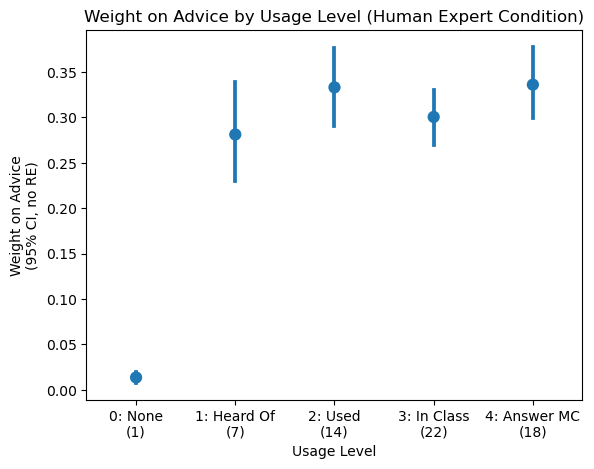

In [599]:
advisor = "expert"
condition_name = "AI Chatbot Condition" if advisor == 'AI chatbot' else "Human Expert Condition"
survey_df['usage_level'] = survey_df[usage_cols].sum(axis=1)
question_df['usage_level'] = question_df[usage_cols].sum(axis=1)
# plot woa by usage level
chatbot_df = question_df[question_df['advisor'] == advisor]
sns.pointplot(x='usage_level', y='weight_on_advice', data=chatbot_df, errorbar=('ci',95), join=False)
plt.title(f'Weight on Advice by Usage Level ({condition_name})')
plt.xlabel('Usage Level')
plt.ylabel('Weight on Advice\n(95% CI, no RE)')
usage_levels = ['None', 'Heard Of', 'Used', 'In Class', 'Answer MC']
x_labels = []
for i, level in enumerate(usage_levels):
    participant_count = len(chatbot_df[chatbot_df['usage_level'] == i]['participant_id'].unique())
    x_labels.append(f"{i}: {level}\n({participant_count})")
plt.gca().set_xticklabels(x_labels)
plt.savefig(f"../figures/woa_by_advisor_{advisor}.png")

Regression `C`. Add usage level with interaction on `advisor`.

In [600]:
formula = "weight_on_advice ~ advisor * give_justification + topic_familiarity + usage_level * advisor"                                                                                               

vcf = {"question_id": "0 + C(question_id)", "participant_id":"0 + C(participant_id)"}  # formula                                                
model = sm.MixedLM.from_formula(formula, groups="group",                                                    
                                vc_formula=vcf, data=question_df)                                                   
result = model.fit()  
regression_results['C'] = result
print(result.summary())

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                        Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         weight_on_advice
No. Observations:         2828            Method:                     REML            
No. Groups:               1               Scale:                      0.1117          
Min. group size:          2828            Log-Likelihood:             -1112.5200      
Max. group size:          2828            Converged:                  Yes             
Mean group size:          2828.0                                                      
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                    0.169    0.081  2.072 0.038  0.009  0.329
advisor[T.expert]                            0.056    0.118  0.472 0

Confidence interval for the coefficient.

In [601]:
print(result.conf_int().loc['usage_level'])

0   -0.000347
1    0.099396
Name: usage_level, dtype: float64


Regression `C2`, which removes the interaction term.

In [602]:
formula = "weight_on_advice ~ advisor * give_justification + topic_familiarity + usage_level"                                                                                               

vcf = {"question_id": "0 + C(question_id)", "participant_id":"0 + C(participant_id)"}  # formula                                                
model = sm.MixedLM.from_formula(formula, groups="group",                                                    
                                vc_formula=vcf, data=question_df)                                                   
result = model.fit()  
regression_results['C2'] = result
print(result.summary())

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                        Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         weight_on_advice
No. Observations:         2828            Method:                     REML            
No. Groups:               1               Scale:                      0.1117          
Min. group size:          2828            Log-Likelihood:             -1110.5342      
Max. group size:          2828            Converged:                  Yes             
Mean group size:          2828.0                                                      
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                    0.211    0.066  3.178 0.001  0.081  0.342
advisor[T.expert]                           -0.036    0.059 -0.618 0

Regression `C3`, which turns usage into a categorical variable.

In [603]:
formula = "weight_on_advice ~ advisor * give_justification + topic_familiarity + C(usage_level)"                                                                                               

vcf = {"question_id": "0 + C(question_id)", "participant_id":"0 + C(participant_id)"}  # formula                                                
model = sm.MixedLM.from_formula(formula, groups="group",                                                    
                                vc_formula=vcf, data=question_df)                                                   
result = model.fit()  
regression_results['C3'] = result
print(result.summary())

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                        Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         weight_on_advice
No. Observations:         2828            Method:                     REML            
No. Groups:               1               Scale:                      0.1117          
Min. group size:          2828            Log-Likelihood:             -1113.1138      
Max. group size:          2828            Converged:                  Yes             
Mean group size:          2828.0                                                      
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                    0.104    0.159  0.652 0.514 -0.208  0.416
advisor[T.expert]                           -0.036    0.060 -0.609 0

Regression `C4`, which specifically tests for the effect of `used`.

In [604]:
formula = "weight_on_advice ~ advisor * give_justification + topic_familiarity + used * advisor"                                                                                               

vcf = {"question_id": "0 + C(question_id)", "participant_id":"0 + C(participant_id)"}  # formula                                                
model = sm.MixedLM.from_formula(formula, groups="group",                                                    
                                vc_formula=vcf, data=question_df)                                                   
result = model.fit()  
regression_results['C4'] = result
print(result.summary())

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                        Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         weight_on_advice
No. Observations:         2828            Method:                     REML            
No. Groups:               1               Scale:                      0.1118          
Min. group size:          2828            Log-Likelihood:             -1109.8673      
Max. group size:          2828            Converged:                  Yes             
Mean group size:          2828.0                                                      
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                    0.183    0.071  2.592 0.010  0.045  0.321
advisor[T.expert]                            0.036    0.107  0.338 0

Regression `D`. Add term for advice quality.

In [605]:
formula = "weight_on_advice ~ advisor * give_justification + topic_familiarity + usage_level * \
    advisor + advice_is_correct"                                                                                                

vcf = {"question_id": "0 + C(question_id)", "participant_id":"0 + C(participant_id)"}  # formula                                                
model = sm.MixedLM.from_formula(formula, groups="group",                                                    
                                vc_formula=vcf, data=question_df)                                                   
result = model.fit()  
regression_results['D'] = result
print(result.summary())

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                        Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         weight_on_advice
No. Observations:         2828            Method:                     REML            
No. Groups:               1               Scale:                      0.1117          
Min. group size:          2828            Log-Likelihood:             -1115.4209      
Max. group size:          2828            Converged:                  Yes             
Mean group size:          2828.0                                                      
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                    0.161    0.082  1.962 0.050  0.000  0.321
advisor[T.expert]                            0.054    0.118  0.463 0

In [606]:
formula = "weight_on_advice ~ advisor * give_justification + topic_familiarity + usage_level * \
    advisor + advice_is_correct * give_justification"                                                                                                

vcf = {"question_id": "0 + C(question_id)", "participant_id":"0 + C(participant_id)"}  # formula                                                
model = sm.MixedLM.from_formula(formula, groups="group",                                                    
                                vc_formula=vcf, data=question_df)                                                   
result = model.fit()  
regression_results['D'] = result
print(result.summary())

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                            Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           weight_on_advice
No. Observations:             2828              Method:                       REML            
No. Groups:                   1                 Scale:                        0.1117          
Min. group size:              2828              Log-Likelihood:               -1117.0180      
Max. group size:              2828              Converged:                    Yes             
Mean group size:              2828.0                                                          
----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                            0.177    0.083  2.142 0.03

Evaluate participant's implied guess at the advice's correctness.

In [607]:
get_advice_prob = lambda row: 0 if row['advice_answer'] not in 'ABCD' else row[f'adjusted_choice{row["advice_answer"]}']
question_df['advice_correct_belief'] = question_df.apply(get_advice_prob, axis=1)

Participants are somewhat able to discern when advice is correct and weight it accordingly. Figure in `Appendix B.1`.

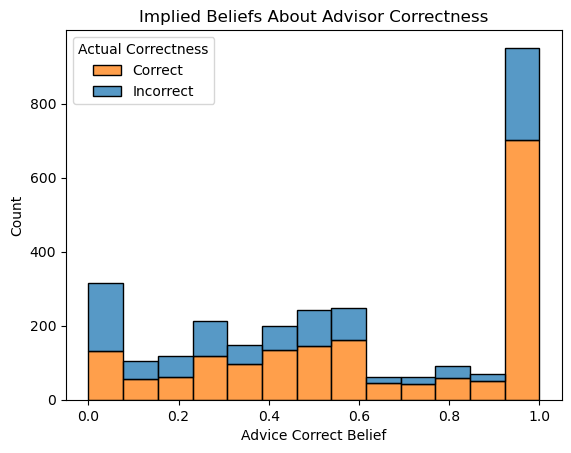

In [608]:
g = sns.histplot(data=question_df, x="advice_correct_belief", hue="advice_is_correct", multiple="stack")
plt.xlabel("Advice Correct Belief")
plt.legend(['Correct', 'Incorrect'], title='Actual Correctness')
plt.title('Implied Beliefs About Advisor Correctness')
plt.savefig('../figures/advice_correctness_belief.png')
plt.show()

Participants vary substantially in the quality of their past advice received.

Mean advice accuracy belief: 62.3%
Standard deviation of advice accuracy belief: 14.6%


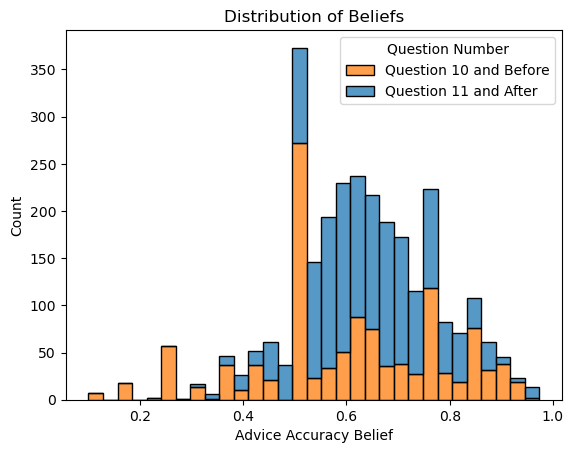

In [609]:
# count of correct and incorrect advice so far
question_df['correct_advice_count'] = question_df.groupby('participant_id', group_keys=False)['advice_is_correct'].apply(lambda x: x.shift(1).cumsum().fillna(0))
question_df['incorrect_advice_count'] = question_df.groupby('participant_id', group_keys=False)['advice_is_correct'].cumcount() - question_df['correct_advice_count']
# beta distribution
prior = (0.5, 0.5) # weak uniform prior
def beta_posterior(row, prior=prior):
    """Calculate the posterior beta distribution for a given row"""
    beta = prior[0] + row['correct_advice_count']
    alpha = prior[1] + row['incorrect_advice_count']
    return beta / (beta + alpha)
question_df['advice_accuracy_belief'] = question_df.apply(beta_posterior, axis=1)
print(f"Mean advice accuracy belief: {question_df['advice_accuracy_belief'].mean():.1%}")
print(f"Standard deviation of advice accuracy belief: {question_df['advice_accuracy_belief'].std():.1%}")
question_df["before_question_10"] = question_df["question_num"] <= 10
sns.histplot(data=question_df, x="advice_accuracy_belief", hue="before_question_10", multiple="stack")
plt.title('Distribution of Beliefs')
plt.legend(['Question 10 and Before', 'Question 11 and After'], title='Question Number')
plt.xlabel('Advice Accuracy Belief')
plt.ylabel('Count')
plt.savefig('../figures/advice_accuracy_belief.png')
plt.show()

Regression `E`. Add the advice accuracy belief.

In [610]:
formula = "weight_on_advice ~ advice_accuracy_belief * advisor + advisor * give_justification + topic_familiarity  + advice_is_correct + usage_level * advisor"                                                

vcf = {"question_id": "0 + C(question_id)", "participant_id":"0 + C(participant_id)"}  # formula                                                
model = sm.MixedLM.from_formula(formula, groups="group",                                                    
                                vc_formula=vcf, data=question_df)                                                   
result = model.fit()  
regression_results['E'] = result
print(result.summary())

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                        Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         weight_on_advice
No. Observations:         2828            Method:                     REML            
No. Groups:               1               Scale:                      0.1117          
Min. group size:          2828            Log-Likelihood:             -1116.4362      
Max. group size:          2828            Converged:                  Yes             
Mean group size:          2828.0                                                      
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                    0.059    0.097  0.604 0.546 -0.132  0.250
advisor[T.expert]                            0.200    0.140  1.428 0

In [611]:
print(result.conf_int().loc['advice_accuracy_belief'])

0   -0.007609
1    0.353376
Name: advice_accuracy_belief, dtype: float64


In [612]:
# standard error on the expert accuracy belief term
col_1 = "advice_accuracy_belief:advisor[T.expert]"
col_2 = "advice_accuracy_belief"
var_1 = result.cov_params()[col_1][col_1]
var_2 = result.cov_params()[col_2][col_2]
cov = result.cov_params()[col_1][col_2]
se = np.sqrt(var_1 + var_2 + 2 * cov)
print(f"SE: {se}")
# test for expert

SE: 0.07985081058647711


In [613]:
coef = result.params["advice_accuracy_belief"] + result.params["advice_accuracy_belief:advisor[T.expert]"]
# 95% ci
print(f"95% CI: {coef - 1.96 * se}, {coef + 1.96 * se}")

95% CI: -0.21721656065768777, 0.0957986168413025


Regression `E2`. Adding a term for the last advice.

In [614]:
question_df['last_advice_is_correct'] = question_df.groupby('participant_id')['advice_is_correct'].shift(1).fillna(0)
formula = "weight_on_advice ~ advice_accuracy_belief * advisor + advisor * give_justification + topic_familiarity + advice_is_correct + usage_level * advisor + last_advice_is_correct * advisor"                                       

vcf = {"question_id": "0 + C(question_id)", "participant_id":"0 + C(participant_id)"}  # formula                                                
model = sm.MixedLM.from_formula(formula, groups="group",                                                    
                                vc_formula=vcf, data=question_df)                                                   
result = model.fit()  
regression_results['E2'] = result
print(result.summary())

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                           Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          weight_on_advice
No. Observations:            2828             Method:                      REML            
No. Groups:                  1                Scale:                       0.1118          
Min. group size:             2828             Log-Likelihood:              -1121.4097      
Max. group size:             2828             Converged:                   Yes             
Mean group size:             2828.0                                                        
-------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------------
Intercept                                         0.067    0.098  0.684 0.494 -0.126  0.260
advisor[T.exper

Regression `E3` through `E7`. Varying the prior.

In [615]:
priors = [(0.05, 0.05), (0.2, 0.2), (1, 1), (0.25, 0.75), (0.75, 0.25)]
reg_numbers = range(3, 8)
for prior, reg_num in zip(priors, reg_numbers):
    question_df['advice_accuracy_belief'] = question_df.apply(beta_posterior, prior=prior, axis=1)
    question_df['last_advice_is_correct'] = question_df.groupby('participant_id')['advice_is_correct'].shift(1).fillna(0)
    formula = "weight_on_advice ~ advice_accuracy_belief * advisor + advisor * give_justification + topic_familiarity + advice_is_correct + usage_level * advisor"                                       

    vcf = {"question_id": "0 + C(question_id)", "participant_id":"0 + C(participant_id)"}  # formula                                                
    model = sm.MixedLM.from_formula(formula, groups="group",                                                    
                                    vc_formula=vcf, data=question_df)                                                   
    result = model.fit()  
    regression_results[f"E{reg_num}"] = result
    print(prior, result.summary())

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


(0.05, 0.05)                         Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         weight_on_advice
No. Observations:         2828            Method:                     REML            
No. Groups:               1               Scale:                      0.1116          
Min. group size:          2828            Log-Likelihood:             -1116.9174      
Max. group size:          2828            Converged:                  Yes             
Mean group size:          2828.0                                                      
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                    0.082    0.090  0.903 0.366 -0.096  0.259
advisor[T.expert]                            0.166    0

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


(0.2, 0.2)                         Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         weight_on_advice
No. Observations:         2828            Method:                     REML            
No. Groups:               1               Scale:                      0.1116          
Min. group size:          2828            Log-Likelihood:             -1116.6762      
Max. group size:          2828            Converged:                  Yes             
Mean group size:          2828.0                                                      
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                    0.072    0.093  0.773 0.440 -0.110  0.254
advisor[T.expert]                            0.181    0.1

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


(1, 1)                         Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         weight_on_advice
No. Observations:         2828            Method:                     REML            
No. Groups:               1               Scale:                      0.1117          
Min. group size:          2828            Log-Likelihood:             -1116.3125      
Max. group size:          2828            Converged:                  Yes             
Mean group size:          2828.0                                                      
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                    0.048    0.103  0.462 0.644 -0.155  0.250
advisor[T.expert]                            0.217    0.147  

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


(0.25, 0.75)                         Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         weight_on_advice
No. Observations:         2828            Method:                     REML            
No. Groups:               1               Scale:                      0.1116          
Min. group size:          2828            Log-Likelihood:             -1116.3025      
Max. group size:          2828            Converged:                  Yes             
Mean group size:          2828.0                                                      
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                    0.084    0.090  0.930 0.353 -0.093  0.261
advisor[T.expert]                            0.187    0

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


(0.75, 0.25)                         Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         weight_on_advice
No. Observations:         2828            Method:                     REML            
No. Groups:               1               Scale:                      0.1118          
Min. group size:          2828            Log-Likelihood:             -1117.4272      
Max. group size:          2828            Converged:                  Yes             
Mean group size:          2828.0                                                      
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                    0.076    0.101  0.751 0.453 -0.122  0.273
advisor[T.expert]                            0.136    0

## Advice Confidence

In [616]:
def extract_confidence(row: pd.Series, answer_type: str) -> None:
    assert answer_type in ['adjusted', 'init']
    for letter in 'ABCD':
        y_prob.append(row[f"{answer_type}_choice{letter}"])
        y_true.append(letter == row['correct_answer'])

ECE initial: 0.18330018109297125
ECE adjusted: 0.1374087492244323


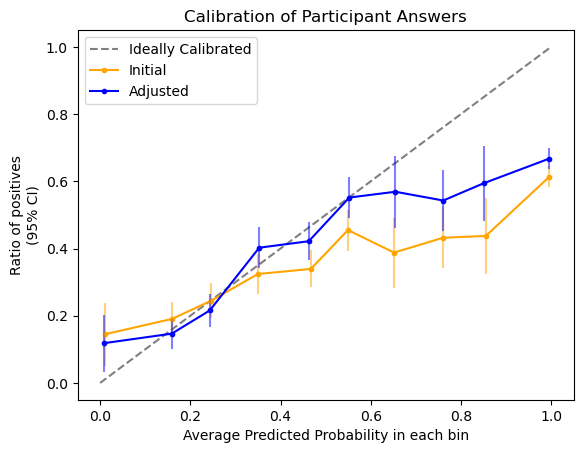

In [617]:
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated', color="grey")

y_true = []
y_prob = []
question_df.apply(extract_confidence, answer_type='init', axis=1)

prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')

color = "orange"

# add error bars
prob_true_err = []
prob_pred_err = []
bucket_sizes = []
for i in range(len(prob_true)):
    bucket_size = len(question_df[(question_df['advice_correct_belief'] >= prob_pred[i]) & (question_df['advice_correct_belief'] < prob_pred[i] + 0.1)])
    prob_true_err.append(1.96*np.sqrt(prob_true[i] * (1 - prob_true[i]) / bucket_size))
    prob_pred_err.append(1.96*np.sqrt(prob_pred[i] * (1 - prob_pred[i]) / bucket_size))
    bucket_sizes.append(bucket_size)

# calculate ece
ece = 0
for i in range(len(prob_true)):
    ece += bucket_sizes[i] * np.abs(prob_true[i] - prob_pred[i])
ece /= len(question_df)
print(f"ECE initial: {ece}")

plt.plot(prob_pred, prob_true, marker = '.', color=color, label="Initial")
plt.errorbar(prob_pred, prob_true, yerr = prob_true_err, color = color, linestyle = '', marker = '.', alpha=.5)
y_true = []
y_prob = []
question_df.apply(extract_confidence, answer_type='adjusted', axis=1)

prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')

color = "blue"

# add error bars
prob_true_err = []
prob_pred_err = []
bucket_sizes = []
for i in range(len(prob_true)):
    bucket_size = len(question_df[(question_df['advice_correct_belief'] >= prob_pred[i]) & (question_df['advice_correct_belief'] < prob_pred[i] + 0.1)])
    prob_true_err.append(1.96*np.sqrt(prob_true[i] * (1 - prob_true[i]) / bucket_size))
    prob_pred_err.append(1.96*np.sqrt(prob_pred[i] * (1 - prob_pred[i]) / bucket_size))
    bucket_sizes.append(bucket_size)

# calculate ece
ece = 0
for i in range(len(prob_true)):
    ece += bucket_sizes[i] * np.abs(prob_true[i] - prob_pred[i])
ece /= len(question_df)
print(f"ECE adjusted: {ece}")

plt.plot(prob_pred, prob_true, marker = '.', color=color, label="Adjusted")
plt.errorbar(prob_pred, prob_true, yerr = prob_true_err, color = color, linestyle = '', marker = '.', alpha=.5)

plt.legend()

plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives\n(95% CI)')
plt.title("Calibration of Participant Answers")
plt.savefig('../figures/calibration_curve_participant.png')
plt.show()

ECE advice: 0.20051850429297674


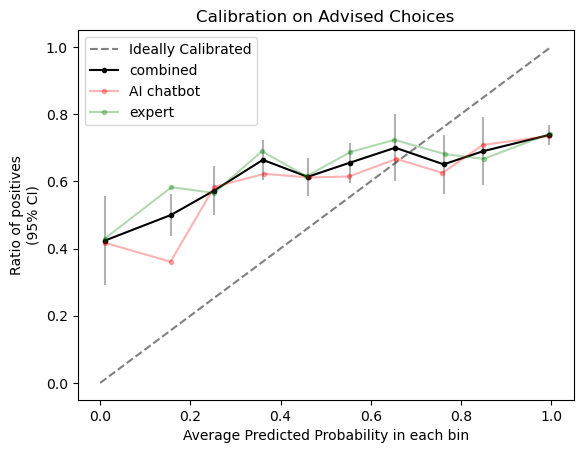

In [618]:
chatbot_df = question_df[question_df['advisor'] == 'AI chatbot']
y_true = question_df['advice_is_correct']
y_prob = question_df['advice_correct_belief']

plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated', color="grey")

prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')

color = "black"

# add error bars
prob_true_err = []
prob_pred_err = []
bucket_sizes = []
for i in range(len(prob_true)):
    bucket_size = len(question_df[(question_df['advice_correct_belief'] >= prob_pred[i]) & (question_df['advice_correct_belief'] < prob_pred[i] + 0.1)])
    prob_true_err.append(1.96*np.sqrt(prob_true[i] * (1 - prob_true[i]) / bucket_size))
    prob_pred_err.append(1.96*np.sqrt(prob_pred[i] * (1 - prob_pred[i]) / bucket_size))
    bucket_sizes.append(bucket_size)

# calcualte ece
ece = 0
for i in range(len(prob_true)):
    ece += bucket_sizes[i] * np.abs(prob_true[i] - prob_pred[i])
ece /= len(question_df)
print(f"ECE advice: {ece}")

plt.plot(prob_pred, prob_true, marker = '.', color=color, label='combined')
plt.errorbar(prob_pred, prob_true, yerr = prob_true_err, color = color, linestyle = '', marker = '.', alpha=0.3)

for advisor, color in zip(['AI chatbot', 'expert'], ['red', 'green']):
    sub_df = question_df[question_df['advisor'] == advisor]
    y_true = sub_df['advice_is_correct'].astype(float)
    y_prob = sub_df['advice_correct_belief']

    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')

    # add error bars
    prob_true_err = []
    prob_pred_err = []
    for i in range(len(prob_true)):
        bucket_size = len(sub_df[(sub_df['advice_correct_belief'] >= prob_pred[i]) & (sub_df['advice_correct_belief'] < prob_pred[i] + 0.1)])
        prob_true_err.append(1.96*np.sqrt(prob_true[i] * (1 - prob_true[i]) / bucket_size))
        prob_pred_err.append(1.96*np.sqrt(prob_pred[i] * (1 - prob_pred[i]) / bucket_size))

    plt.plot(prob_pred, prob_true, marker = '.', color=color, label = advisor, alpha = 0.3)

plt.legend()
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives\n(95% CI)')
plt.title("Calibration on Advised Choices")
plt.savefig('../figures/calibration_curve_advice.png')
plt.show()

In [619]:
high = prob_true[0] + prob_true_err[0]
low = prob_true[0] - prob_true_err[0]
print(f"{prob_true[0]:.1%} 95% CI: [{low:.1%}, {high:.1%}]")

42.9% 95% CI: [24.6%, 61.3%]


In [620]:
# calculate expected calibration error
np.average(np.abs(prob_true - prob_pred), weights=bucket_sizes)

0.24652866521124686

In [621]:
def calculate_ece(df):
    prob_true, prob_pred = calibration_curve(df['advice_is_correct'].astype(float), df['advice_correct_belief'], n_bins=10, strategy='uniform')
    bucket_sizes = []
    for i in range(len(prob_true)):
        bucket_size = len(df[(df['advice_correct_belief'] >= prob_pred[i]) & (df['advice_correct_belief'] < prob_pred[i] + 0.1)])
        bucket_sizes.append(bucket_size)
    return np.average(np.abs(prob_true - prob_pred), weights=bucket_sizes)

RESAMPLES = 1000
CI = 0.95

# calculate ece by question group
ece_data = []
for question_group, group_df in question_df.groupby('question_group'):
    ece_obs = {'question_group':question_group}
    ece_obs['ece'] = calculate_ece(group_df)

    # bootstrap 95% confidence interval
    estimates = []
    for i in range(RESAMPLES):
        sample = group_df.sample(frac=1, replace=True)
        estimates.append(calculate_ece(sample))
    estimates = np.array(estimates)
    ece_obs['ece_ci'] = (np.quantile(estimates, (1-CI)/2), np.quantile(estimates, CI + (1-CI)/2))
    ece_data.append(ece_obs)

ece_df = pd.DataFrame(ece_data)

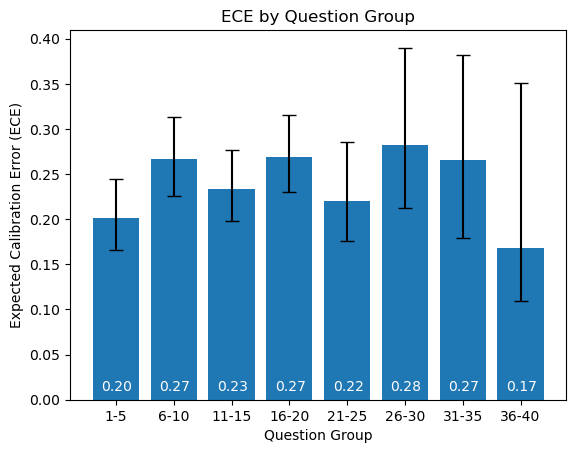

In [622]:
# plot barplot
plt.bar([f'{i}-{i+4}' for i in range(1, 41, 5)],
        ece_df['ece'],
        yerr=[ece_df['ece'] - ece_df['ece_ci'].apply(lambda x: x[0]),
              ece_df['ece_ci'].apply(lambda x: x[1]) - ece_df['ece']],
              capsize=5,
        ecolor='black')
plt.xlabel('Question Group')
plt.ylabel('Expected Calibration Error (ECE)')
plt.title('ECE by Question Group')
# add data labels
for i, v in enumerate(ece_df['ece']):
    plt.text(i - 0.25, 0.01, f"{v:.2f}", color='white')
plt.savefig('../figures/ece_by_question_group.png')

<AxesSubplot: ylabel='Frequency'>

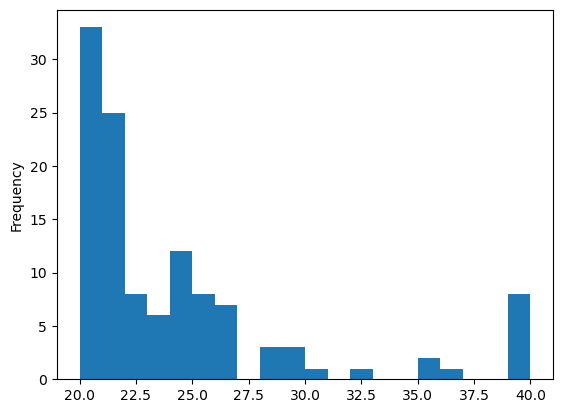

In [623]:
question_df.groupby('participant_id')['question_num'].max().plot.hist(bins=20)

Analysis by topic.

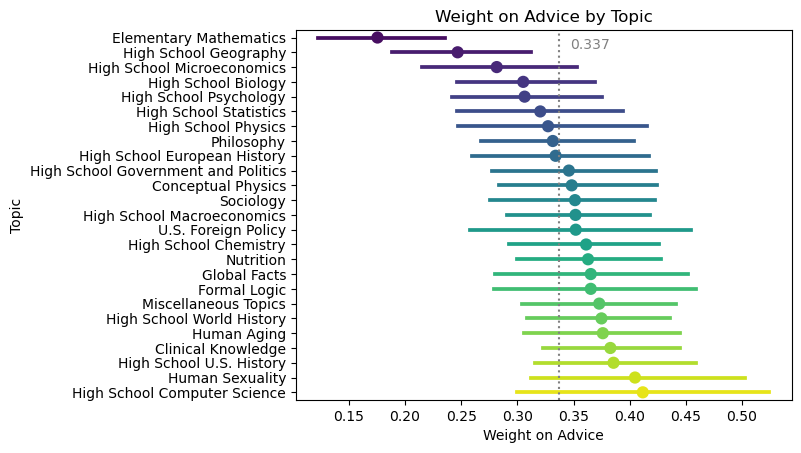

In [624]:
 # list of topics by mean weight on advice
sorted_topics = question_df.groupby('topic')['weight_on_advice'].mean().sort_values().index
# color by woa
ax = sns.pointplot(data=question_df, x="weight_on_advice", y="topic", join=False, seed=0, orient='h', order = sorted_topics, errorbar=('ci',95), palette='viridis')
topic_labels = list(map(lambda t: config.topic2display[t._text], ax.get_yticklabels()))
ax.set_yticklabels(topic_labels)


average_woa = question_df['weight_on_advice'].mean()
plt.axvline(average_woa, color='grey', linestyle='dotted', label='Average Weight on Advice')

plt.text(average_woa + 0.01, 0.5, str(round(average_woa, 3)), color='grey', verticalalignment='center')

plt.xlabel('Weight on Advice')
plt.ylabel('Topic')
plt.title('Weight on Advice by Topic')
plt.show()

In [625]:
question_df['supercategory'] = question_df['topic'].apply(config.topic2category.get)

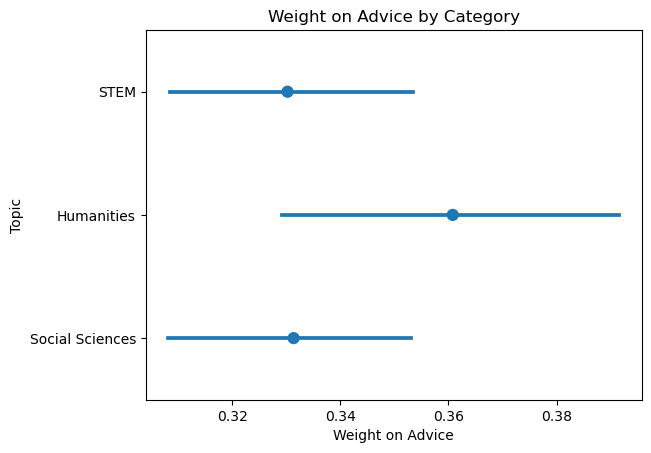

In [626]:
ax = sns.pointplot(data=question_df, x="weight_on_advice", y="supercategory", join=False, seed=0, orient='h', errorbar=('ci',95))
topic_labels = list(map(lambda t: config.category2display[t._text], ax.get_yticklabels()))
ax.set_yticklabels(topic_labels)
plt.xlabel('Weight on Advice')
plt.ylabel('Topic')
plt.title('Weight on Advice by Category')
plt.show()

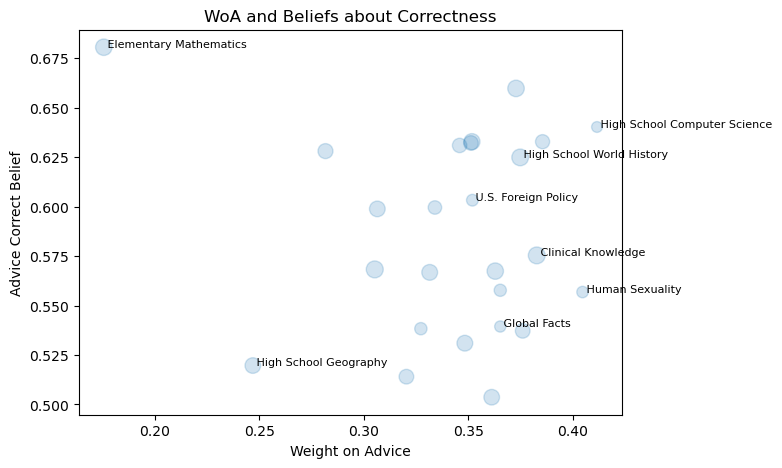

In [627]:
plt.figure(figsize=(7, 5))
woa_and_correctness_df = question_df.groupby('topic')[['weight_on_advice', 'advice_correct_belief']].agg(['mean','count'])
# scatterplot
plt.scatter(woa_and_correctness_df['weight_on_advice']['mean'],
            woa_and_correctness_df['advice_correct_belief']['mean'],
            s=woa_and_correctness_df['advice_correct_belief']['count'], 
            alpha=.2)
# annotate
keep_topics = ['elementary_mathematics','high_school_geography','high_school_computer_science','human_sexuality','global_facts','clinical_knowledge','high_school_world_history','us_foreign_policy','formal logic']

for i, topic in enumerate(woa_and_correctness_df.index):
    if topic not in keep_topics:
        continue
    x = woa_and_correctness_df['weight_on_advice']['mean'][i]
    y = woa_and_correctness_df['advice_correct_belief']['mean'][i]
    display_text = " " + config.topic2display[topic]
    plt.annotate(display_text, (x, y), fontsize=8)

plt.xlabel('Weight on Advice')
plt.ylabel('Advice Correct Belief')
plt.title('WoA and Beliefs about Correctness')
plt.savefig('../figures/woa_and_correctness.png')
plt.show()

In [628]:
pearsonr(question_df['weight_on_advice'], question_df['advice_correct_belief'])

(0.6383270132365294, 2e-323)

In [629]:
model_result_df = pd.read_csv('../data/model_output/results_0425.csv')
model_result_df = model_result_df[model_result_df['topic'].isin(config.topics)]
model_result_df['answer_correct'] = model_result_df['answer'] == model_result_df['correct_answer']

In [630]:
# conduct t-tests by topic
topic2significance = {}
all_correctness, all_beliefs = [], []
for topic in config.topics:
    correctness = model_result_df[model_result_df['topic'] == topic]['answer_correct']
    beliefs = question_df[question_df['topic'] == topic]['advice_correct_belief']
    t, p = brunnermunzel(correctness, beliefs)
    topic2significance[topic] = p
    all_correctness.append(correctness.mean())
    all_beliefs.append(beliefs.mean())

# FDR correction
rejections = fdrcorrection(list(topic2significance.values()))
topic2reject = dict(zip(topic2significance.keys(), rejections[0]))
pearsonr(all_correctness, all_beliefs)

(0.5130053083590845, 0.008730397121904059)

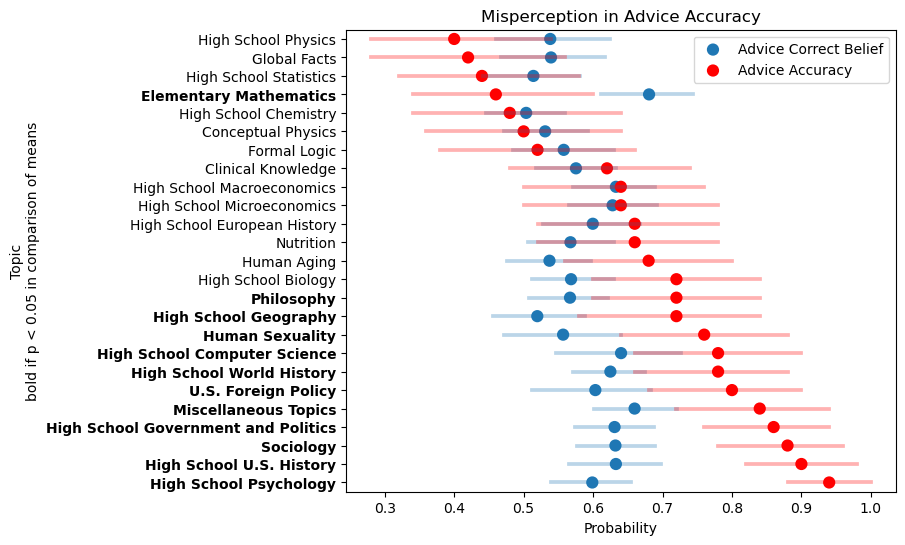

In [631]:
SIG_LEVEL = 0.05
plt.figure(figsize=(10, 6))
sorted_topics = model_result_df.groupby('topic')['answer_correct'].mean().sort_values().index
ax1 = sns.pointplot(data=question_df, x="advice_correct_belief", y="topic", label='Advice Correct Belief', errorbar=('ci', 95), join=False, orient='h', order = sorted_topics)
ax2 = sns.pointplot(data=model_result_df, x="answer_correct", y="topic", label='Advice Accuracy', color='red', errorbar=('ci', 95), join=False, orient='h', order = sorted_topics)
topic_labels = list(map(lambda t: config.topic2display[t._text], ax1.get_yticklabels()))

ax1.set_yticklabels(topic_labels)

display2topic = {v:k for k,v in config.topic2display.items()}

for tick in ax1.get_yticklabels():
    topic = display2topic[tick._text]
    if topic2reject[topic]:
        tick.set_fontweight('bold')
    else:
        tick.set_fontweight('normal')

for line in ax1.lines:
    line.set_alpha(0.3)
for line in ax2.lines:
    line.set_alpha(0.3)

plt.subplots_adjust(left=0.35)
plt.xlabel('Probability')
plt.ylabel(f"Topic\nbold if p < {SIG_LEVEL:.2f} in comparison of means")
plt.title('Misperception in Advice Accuracy')
plt.legend()

# set sigdif topics to be bold
ax = plt.gca()
plt.savefig('../figures/misperception_in_advice_accuracy.png')

plt.show()

Calculating optimal weight on advice.

In [632]:
def brier_score(row: pd.Series, type: str) -> float:
    """Calculate the Brier score for a single row."""
    assert type in ['init', 'adjusted', 'simulated']
    return sum((row[f"{type}_choice{letter_choice}"] - int(letter_choice == row['correct_answer'])) ** 2 for letter_choice in "ABCD")

In [633]:
def take_advice(row: pd.Series, weight_on_advice_logg: float):
    """Simulate taking advice from the AI chatbot."""
    assert 0 <= weight_on_advice_logg <= 1
    
    simulated_choices = []
    advice_choice = row[f"advice_answer"]

    if advice_choice not in "ABCD":
        return pd.Series(list(row[[f"init_choice{letter_choice}" for letter_choice in "ABCD"]]))

    advice_gap = 1 - row[f"init_choice{advice_choice}"]
    scale_factor = advice_gap * weight_on_advice_logg
    
    for letter_choice in "ABCD":
        weight = row[f"init_choice{letter_choice}"] * (1 - scale_factor)
        if letter_choice == advice_choice:
            weight += scale_factor
        simulated_choices.append(weight)

    return pd.Series(simulated_choices)

In [634]:
WOAs = np.linspace(0, 1, 101)
brier_scores = []
for woa in tqdm(WOAs):
    simulated_df = question_df.apply(take_advice, weight_on_advice_logg=woa, axis=1)
    simulated_df.columns = [f"simulated_choice{letter_choice}" for letter_choice in "ABCD"]
    question_df[simulated_df.columns] = simulated_df
    question_df['simulated_answer'] =  question_df.apply(pick_answer, axis=1, type='simulated')
    question_df['simulated_answer_correct'] = question_df['simulated_answer'] == question_df['correct_answer']
    question_df['simulated_brier_score'] = question_df.apply(brier_score, type='simulated', axis=1)
    brier_scores.append(question_df['simulated_brier_score'].mean())

100%|██████████| 101/101 [00:37<00:00,  2.72it/s]


In [635]:
# adjusted brier score
question_df['adjusted_brier_score'] = question_df.apply(brier_score, type='adjusted', axis=1)
average_bs = question_df['adjusted_brier_score'].mean()

In [636]:
optimal_woa = WOAs[np.argmin(brier_scores)]
print(f"Optimal WOA: {optimal_woa:.3f}\nOptiaml Brier score: {min(brier_scores):.3f}")
average_woa = question_df['weight_on_advice'].mean()
print(f"Average WOA: {average_woa:.3f}\nAverage Brier score: {average_bs:.3f}")

Optimal WOA: 0.630
Optiaml Brier score: 0.542
Average WOA: 0.337
Average Brier score: 0.674


In [637]:
# closest woa to average woa
closest_index = np.argmin(np.abs(WOAs - average_woa))
closest_woa = WOAs[closest_index]
print(f"Closest WOA to average WOA: {closest_woa:.3f}, Brier score: {brier_scores[closest_index]:.3f}")

Closest WOA to average WOA: 0.340, Brier score: 0.588


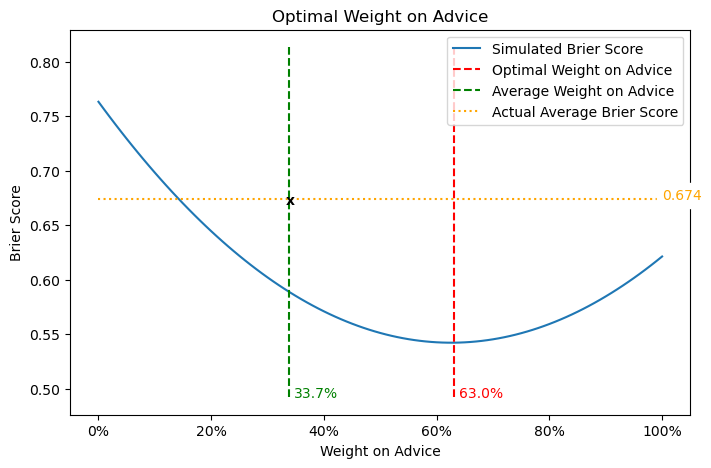

In [638]:
plt.figure(figsize=(8, 5))
plt.plot(WOAs, brier_scores, label='Simulated Brier Score')
plt.xlabel('Weight on Advice')
plt.ylabel('Brier Score')
plt.vlines(optimal_woa, min(brier_scores) - .05, max(brier_scores) + .05, linestyles='dashed', colors='red', label='Optimal Weight on Advice')
plt.annotate(f"{optimal_woa:.1%}", (optimal_woa + .01, min(brier_scores) - .05), fontsize=10, color='red')
plt.vlines(average_woa, min(brier_scores) - .05, max(brier_scores) + .05, linestyles='dashed', colors='green', label='Average Weight on Advice')
plt.annotate(f"{average_woa:.1%}", (average_woa + .01, min(brier_scores) - .05), fontsize=10, color='green')
plt.hlines(average_bs, 0, max(WOAs), linestyles='dotted', colors='orange', label='Actual Average Brier Score')
plt.annotate(f"{average_bs:.3f}", (max(WOAs), average_bs), fontsize=10, color='orange', backgroundcolor='white')
plt.annotate("x", (average_woa - .0045, average_bs - .0045), fontweight="bold")
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.title('Optimal Weight on Advice')
plt.legend()
plt.savefig('../figures/woa_brier_score.png')
plt.show()

In [639]:
sim_df = question_df.copy()
def sim_proportionate(row):
    new_row = row.copy()
    advice_answer = row['advice_answer']
    if advice_answer not in "ABCD":
        return new_row

    abs_change = (1 - row[f"init_choice{advice_answer}"]) * row['weight_on_advice']
    
    new_row['simulated_choiceA'] = row['init_choiceA'] * (1 - abs_change)
    new_row['simulated_choiceB'] = row['init_choiceB'] * (1 - abs_change)
    new_row['simulated_choiceC'] = row['init_choiceC'] * (1 - abs_change)
    new_row['simulated_choiceD'] = row['init_choiceD'] * (1 - abs_change)
    new_row[f"simulated_choice{row['advice_answer']}"] += abs_change
    return new_row
sim_df = sim_df.apply(sim_proportionate, axis=1)
sim_df['brier_score'] = sim_df.apply(brier_score, type='simulated', axis=1)
sim_df['brier_score'].mean()

0.643553016375555

In [640]:
avg_woa = question_df['weight_on_advice'].mean()
sim_df = question_df.copy()
def sim_depolarize(row, scale=.5):
    """
    Simulate a shrinking of the weight on advice towards average but
    proportionately maintaining other adjusted answers.
    """
    new_row = row.copy()

    advice_answer = row['advice_answer'] 
    if advice_answer not in "ABCD":
        for letter in "ABCD":
            new_row[f"simulated_choice{letter}"] = row[f"init_choice{letter}"]
        return new_row

    advice_weight = row[f"adjusted_choice{advice_answer}"]
    woa = row['weight_on_advice'] * (1 - row[f"init_choice{advice_answer}"])
    new_woa = avg_woa * (1 - scale) + woa * scale
    new_row['weight_on_advice'] = new_woa
    new_advice_weight = new_woa + row[f"init_choice{advice_answer}"]

    if advice_weight != 1:
        for letter in "ABCD":
            new_row[f"simulated_choice{letter}"] = row[f"adjusted_choice{letter}"]  / (1-advice_weight) * (1-new_advice_weight)
    else:
        for letter in "ABCD":
            new_row[f"simulated_choice{letter}"] = (1-new_advice_weight) / 3
    new_row[f"simulated_choice{advice_answer}"] = new_advice_weight

    return new_row

In [641]:
Ss = np.linspace(0, 1, 101)
brier_scores = []
for s in tqdm(Ss):
    sim_df = sim_df.apply(sim_depolarize, axis=1, scale=s)
    sim_df['brier_score'] = sim_df.apply(brier_score, type='simulated', axis=1)
    bs = sim_df['brier_score'].mean()
    brier_scores.append(bs)

100%|██████████| 101/101 [00:38<00:00,  2.64it/s]


In [642]:
# calculate optimal s
optimal_s = Ss[np.argmin(brier_scores)]
print(f"Optimal s: {optimal_s:.3f}\nOptiaml Brier score: {min(brier_scores):.3f}")

Optimal s: 0.560
Optiaml Brier score: 0.577


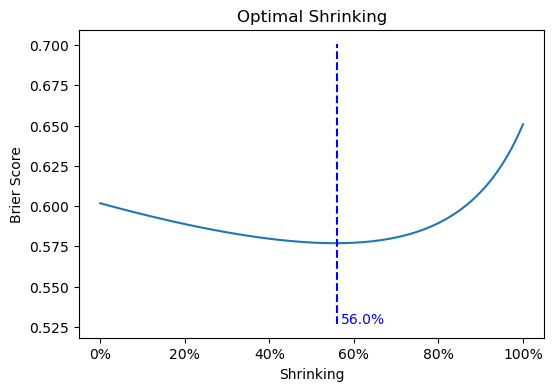

In [643]:
# plot scaling
plt.figure(figsize=(6, 4))
plt.plot(Ss, brier_scores, label='Simulated Brier Score')
plt.xlabel('Shrinking')
plt.ylabel('Brier Score')
plt.vlines(optimal_s, min(brier_scores) - .05, max(brier_scores) + .05, linestyles='dashed', colors='blue', label='Optimal Scaling')
plt.annotate(f"{optimal_s:.1%}", (optimal_s + .01, min(brier_scores) - .05), fontsize=10, color='blue')
plt.title('Optimal Shrinking')
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.savefig('../figures/shrinking_brier_score.png')

In [644]:
Ss = np.linspace(0, 1, 101)
brier_scores = []
for s in tqdm(Ss):
    sim_df = sim_df.apply(sim_depolarize, axis=1, scale=s).apply(sim_proportionate, axis=1)
    sim_df['brier_score'] = sim_df.apply(brier_score, type='simulated', axis=1)
    bs = sim_df['brier_score'].mean()
    brier_scores.append(bs)

100%|██████████| 101/101 [01:10<00:00,  1.43it/s]


In [645]:
# calculate optimal s
optimal_s = Ss[np.argmin(brier_scores)]
print(f"Optimal s: {optimal_s:.3f}\nOptiaml Brier score: {min(brier_scores):.3f}")

Optimal s: 0.000
Optiaml Brier score: 0.589


## Qualitative Responses

Visualize open-ended responses.

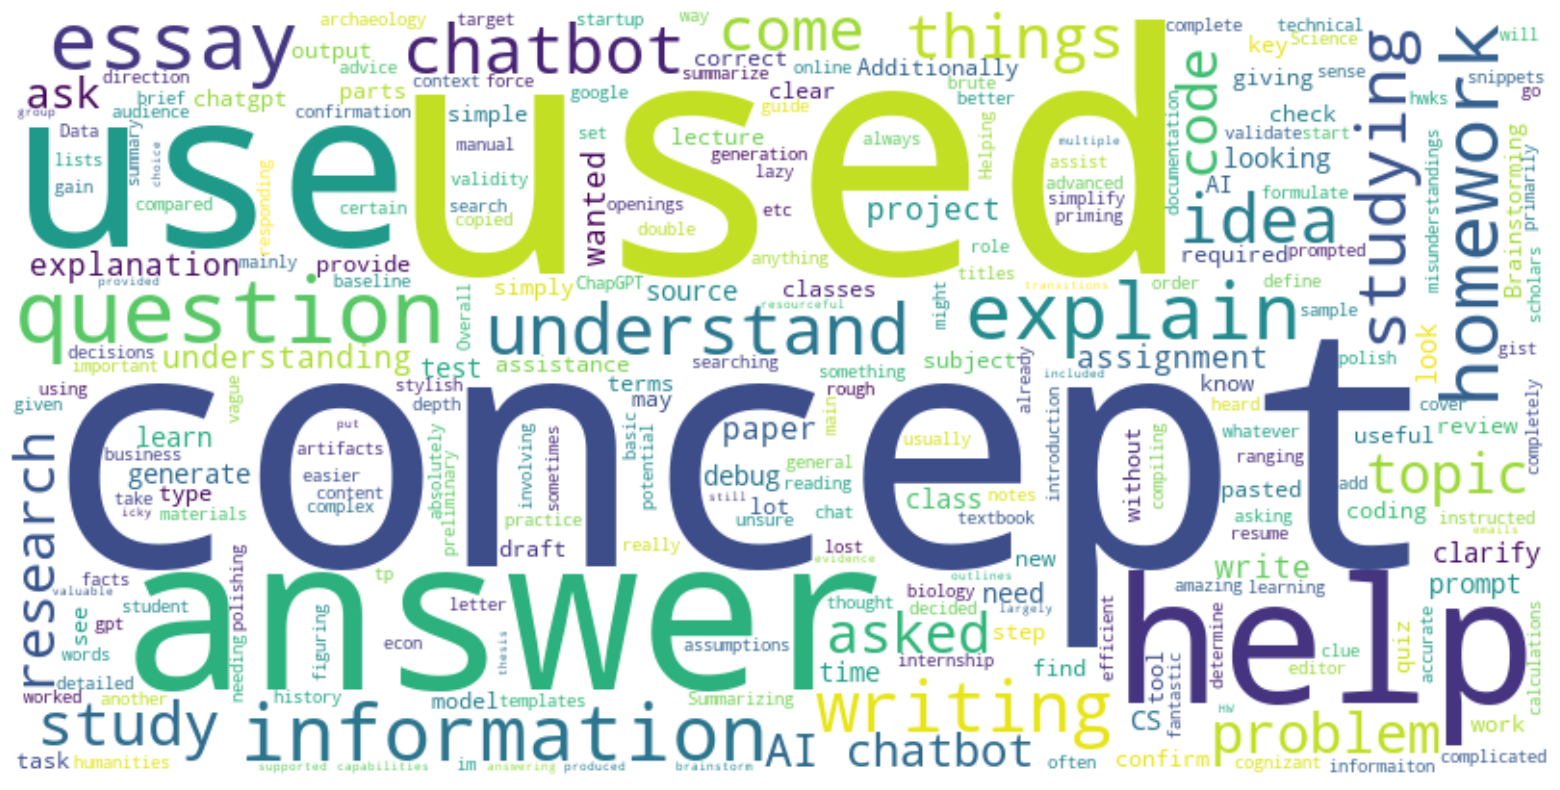

In [646]:
usages = list(map(str, survey_df["usage_description"].dropna()))
# word cloud with bigrams
wordcloud = WordCloud(width=800,
                      height=400,
                      background_color="white",
                      max_words=300,
                      contour_width=3,
                      contour_color='steelblue',
                      collocations=True,
                      random_state=3)
wordcloud.generate(" ".join(usages))
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('../figures/usage_wordcloud.png')

In [647]:
print('\n'.join(usages))

i would ask the chatbot questions that i would like it to answer
To understand complicated concepts.
type key words for it to define
I used them to clarify concepts or brute force problems.
study for homework. It is a lot more efficient when understanding the gist of something 
I used it to help explain a concept that I didn't understand from a textbook
I use it to sometimes get a general sense of what an essay question is asking me and then using that informaiton to write my own answer
Writing essays, giving basic information
I used it to help understand a concept more. 
i would ask it questions and to answer things
used for learning and studying concepts
for easier explanations of topics
chatgpt for archaeology essay when looking up artifacts
Summarizing reading materials to understand more
Help study for classes or get ideas for essays or projects in coding.
I use it for studying just as advanced google searching and for idea generation.
I had an assignment that required/instructed 

## Print Regression Tables

In [648]:
model_names = ["A", "B", "C", "D", "E"]
summary = summary_col(
    [regression_results[model_name] for model_name in model_names],
    stars=True,
    float_format='%0.3f',
    regressor_order=model_names,
    model_names=model_names)
print(summary)
latex = summary.as_latex()
# write latex
with open('../tables/regression_results.tex', 'w') as f:
    f.write(latex)


                                                       A        B        C        D        E    
------------------------------------------------------------------------------------------------
Intercept                                           0.329*** 0.302*** 0.169**  0.177**  0.059   
                                                    (0.044)  (0.045)  (0.081)  (0.083)  (0.097) 
advice_accuracy_belief                                                                  0.173*  
                                                                                        (0.092) 
advice_accuracy_belief:advisor[T.expert]                                                -0.234* 
                                                                                        (0.121) 
advice_is_correct[T.True]                                                      -0.010   0.015   
                                                                               (0.021)  (0.015) 
advice_is_correct[T.True]:giv

In [649]:
model_names = ["B", "B2", "B3"]
summary = summary_col(
    [regression_results[model_name] for model_name in model_names],
    stars=True,
    float_format='%0.3f',
    regressor_order=model_names,
    model_names=model_names)
print(summary)
latex = summary.as_latex()
# write latex
with open('../tables/familiarity_regression_results.tex', 'w') as f:
    f.write(latex)


                                                        B        B2       B3   
-------------------------------------------------------------------------------
Intercept                                            0.302*** 0.311*** 0.299***
                                                     (0.045)  (0.052)  (0.048) 
advisor[T.expert]                                    -0.028   -0.028   -0.012  
                                                     (0.059)  (0.066)  (0.064) 
advisor[T.expert]:give_justification[T.yes]          -0.021   -0.024   -0.025  
                                                     (0.079)  (0.088)  (0.080) 
give_justification[T.yes]                            0.056    0.060    0.058   
                                                     (0.058)  (0.064)  (0.058) 
participant_id Var                                   0.362*** 0.479*** 0.367***
                                                     (0.055)  (0.091)  (0.056) 
question_id Var                        

In [650]:
model_names = ["C"] + [f"C{i}" for i in range(2, 5)]
summary = summary_col(
    [regression_results[model_name] for model_name in model_names],
    stars=True,
    float_format='%0.3f',
    regressor_order=model_names,
    model_names=model_names)
print(summary)
latex = summary.as_latex()
# write latex
with open('../tables/past_usage_regression_results.tex', 'w') as f:
    f.write(latex)


                                               C        C2       C3       C4   
-------------------------------------------------------------------------------
C(usage_level)[T.1]                                           0.117            
                                                              (0.160)          
C(usage_level)[T.2]                                           0.230            
                                                              (0.157)          
C(usage_level)[T.3]                                           0.189            
                                                              (0.156)          
C(usage_level)[T.4]                                           0.241            
                                                              (0.156)          
Intercept                                   0.169**  0.211*** 0.104    0.183***
                                            (0.081)  (0.066)  (0.159)  (0.071) 
advisor[T.expert]                      

In [651]:
model_names = ["E"] + [f"E{i}" for i in range(2, 8)]
summary = summary_col(
    [regression_results[model_name] for model_name in model_names],
    stars=True,
    float_format='%0.3f',
    regressor_order=model_names,
    model_names=model_names)
print(summary)
latex = summary.as_latex()
# write latex
with open('../tables/experience_regression_results.tex', 'w') as f:
    f.write(latex)


                                                    E        E2       E3       E4       E5       E6       E7   
---------------------------------------------------------------------------------------------------------------
Intercept                                        0.059    0.067    0.082    0.072    0.048    0.084    0.076   
                                                 (0.097)  (0.098)  (0.090)  (0.093)  (0.103)  (0.090)  (0.101) 
advice_accuracy_belief                           0.173*   0.146    0.132*   0.149*   0.194*   0.141*   0.133   
                                                 (0.092)  (0.103)  (0.068)  (0.077)  (0.111)  (0.074)  (0.094) 
advice_accuracy_belief:advisor[T.expert]         -0.234*  -0.255*  -0.176*  -0.200*  -0.265*  -0.222** -0.132  
                                                 (0.121)  (0.135)  (0.090)  (0.102)  (0.144)  (0.098)  (0.125) 
advice_is_correct[T.True]                        0.015    0.014    0.015    0.015    0.015    0.014    